In [4]:
from datasets import load_dataset

# Load dataset split
# Adjust split name if needed (e.g., "test", "validation")
ds = load_dataset("rod-motta/wpp-images", split="train")
print(ds)

# Example: access an image (PIL.Image)
image = ds[0]["image"]
image.size  # (width, height)

Dataset({
    features: ['image'],
    num_rows: 121
})


(256, 256)

In [5]:
import math
import torch
from transformers import AutoImageProcessor, AutoModel

pretrained_model_name = "facebook/dinov3-vitl16-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
model = AutoModel.from_pretrained(
    pretrained_model_name,
    device_map="auto",
)

# Batch-encode entire dataset
batch_size = 16
embeddings_list = []

for start in range(0, len(ds), batch_size):
    end = min(start + batch_size, len(ds))
    batch_images = [ds[i]["image"] for i in range(start, end)]
    inputs = processor(images=batch_images, return_tensors="pt").to(model.device)
    with torch.inference_mode():
        outputs = model(**inputs)
    # DINOv3 uses pooled output
    pooled = outputs.pooler_output  # (B, D)
    embeddings_list.append(pooled.cpu())

embeddings = torch.cat(embeddings_list, dim=0)
print("Embeddings shape:", embeddings.shape)

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 11037.64it/s]

Embeddings shape: torch.Size([121, 1024])


<Axes: >

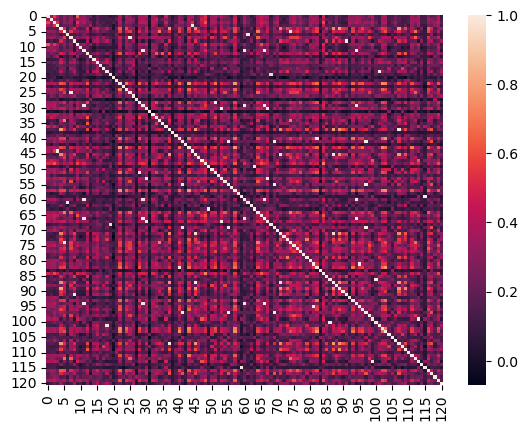

In [8]:
import torch
import numpy as np
import seaborn as sns

# Normalize embeddings and compute cosine similarity
emb_norm = torch.nn.functional.normalize(embeddings, p=2, dim=1)
cosine_sim_matrix = emb_norm @ emb_norm.T

# Optionally subsample for visualization if dataset is large
max_to_show = 200
if cosine_sim_matrix.shape[0] > max_to_show:
    idx = torch.linspace(0, cosine_sim_matrix.shape[0]-1, steps=max_to_show).long()
    cosine_sim_matrix = cosine_sim_matrix[idx][:, idx]

sns.heatmap(cosine_sim_matrix.cpu().numpy())

In [ ]:
import importlib.util
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Determine best attention implementation available
has_flash_attn = importlib.util.find_spec("flash_attn") is not None
ATTN_IMPL = "flash_attention_2" if (DEVICE == "cuda" and has_flash_attn) else "sdpa"

# Pick a sample from the dataset for VLM demo
image_aux = ds[0]["image"]

# Initialize processor and model
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-500M-Instruct")
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceTB/SmolVLM-500M-Instruct",
    dtype=torch.bfloat16,
    _attn_implementation=ATTN_IMPL,
).to(DEVICE)

# Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Can you describe this image?"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image_aux], return_tensors="pt").to(DEVICE)

# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=200)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts[0])

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 24456.58it/s]


User:




Can you describe this image?
Assistant: The image is a colorful poster that appears to be a greeting card. The background of the poster is a vibrant green field with a few trees and bushes, suggesting a natural setting. The sky is a clear blue, indicating a sunny day.

At the top of the poster, there is a large, bold, white text that reads "FELIZ QUARTA-FEIRA!" which translates to "Happy Birthday" in English. Below this, there is a smaller, smaller text that reads "Qué Deus nos abençoe nesse dia e nos faz como força, foi e gratídão." This translates to "What God gave us, we should use as a force, he gave us as a gift."

In the middle of the poster, there is a colorful floral pattern with various flowers, including yellow, red, and blue ones, arranged in a way that suggests a natural, outdoor setting. The flowers are placed


In [32]:
# Generate descriptions for all images using SmolVLM
import torch

assert 'processor' in globals() and 'model' in globals(), "VLM processor/model not initialized. Run the VLM cell above first."

#prompt_text = "Describe this image concisely in one sentence."
prompt_text = "Can you describe this image?"

descriptions = []

for i in range(len(ds)):
    image = ds[i]["image"]
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt_text},
            ],
        }
    ]
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[image], return_tensors="pt").to(DEVICE)

    with torch.inference_mode():
        generated_ids = model.generate(**inputs, max_new_tokens=128)
        generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

    # Keep only the Assistant part of the response
    full_text = generated_texts[0]
    assistant_text = full_text.split("Assistant:", 1)[1].strip() if "Assistant:" in full_text else full_text.strip()
    descriptions.append(assistant_text)
    if (i + 1) % 10 == 0 or (i + 1) == len(ds):
        print(f"Generated {i + 1}/{len(ds)} descriptions")

print("Example:", descriptions[0] if descriptions else "<no data>")


Generated 10/121 descriptions
Generated 20/121 descriptions
Generated 30/121 descriptions
Generated 40/121 descriptions
Generated 50/121 descriptions
Generated 60/121 descriptions
Generated 70/121 descriptions
Generated 80/121 descriptions
Generated 90/121 descriptions
Generated 100/121 descriptions
Generated 110/121 descriptions
Generated 120/121 descriptions
Generated 121/121 descriptions
Example: The image is a colorful poster that appears to be a greeting card. The background of the poster is a vibrant green field with a few trees and bushes, suggesting a natural setting. The sky is a clear blue, indicating a sunny day.

At the top of the poster, there is a large, bold, white text that reads "FELIZ QUARTA-FEIRA!" which translates to "Happy Birthday" in English. Below this, there is a smaller, smaller text that reads "Qué Deus nos abençoe nesse dia e nos faz como força, foi e


In [34]:
# Compute OpenAI embeddings for descriptions and save everything
import os
import csv
import numpy as np
from typing import List

# Requires OPENAI_API_KEY in environment
try:
    from openai import OpenAI
except Exception as e:
    raise RuntimeError("Please install openai: pip install openai>=1.40.0") from e

assert 'descriptions' in globals(), "Descriptions not found. Run the previous cell first."

# Prepare export directories
images_dir = os.path.join("artifacts", "export", "images")
os.makedirs(images_dir, exist_ok=True)
os.makedirs(os.path.join("artifacts", "export"), exist_ok=True)

# Save images and collect paths
image_paths: List[str] = []
for i in range(len(ds)):
    p = os.path.join(images_dir, f"image_{i:05d}.png")
    ds[i]["image"].save(p)
    image_paths.append(p)

# Use previously computed image embeddings (DINOv3)
assert 'embeddings' in globals(), "Image embeddings tensor `embeddings` missing. Run the DINOv3 cell."
img_emb = embeddings.cpu().numpy().astype(np.float32)

# OpenAI embeddings
client = OpenAI()
model_name = "text-embedding-3-small"

# Batch embedding calls to respect rate limits
def batch(iterable, n):
    for idx in range(0, len(iterable), n):
        yield iterable[idx: idx + n]

text_embeds: List[np.ndarray] = []
BATCH = 128
for chunk in batch(descriptions, BATCH):
    resp = client.embeddings.create(model=model_name, input=chunk)
    vecs = [np.array(d.embedding, dtype=np.float32) for d in resp.data]
    text_embeds.extend(vecs)

text_emb = np.stack(text_embeds, axis=0)

# # Save arrays and manifest
# export_dir = os.path.join("artifacts", "export")
# np.savez_compressed(os.path.join(export_dir, "image_embeddings.npz"), embeddings=img_emb)
# np.savez_compressed(os.path.join(export_dir, "text_embeddings.npz"), embeddings=text_emb)

# manifest_path = os.path.join(export_dir, "manifest.csv")
# with open(manifest_path, "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerow(["index", "image_path", "description"])  # minimal manifest; embeddings in npz
#     for i, (path, desc) in enumerate(zip(image_paths, descriptions)):
#         writer.writerow([i, path, desc])

# print("Saved:")
# print("- images ->", images_dir)
# print("- image_embeddings.npz ->", os.path.join(export_dir, "image_embeddings.npz"))
# print("- text_embeddings.npz ->", os.path.join(export_dir, "text_embeddings.npz"))
# print("- manifest.csv ->", manifest_path)


In [35]:
descriptions

['The image is a colorful poster that appears to be a greeting card. The background of the poster is a vibrant green field with a few trees and bushes, suggesting a natural setting. The sky is a clear blue, indicating a sunny day.\n\nAt the top of the poster, there is a large, bold, white text that reads "FELIZ QUARTA-FEIRA!" which translates to "Happy Birthday" in English. Below this, there is a smaller, smaller text that reads "Qué Deus nos abençoe nesse dia e nos faz como força, foi e',
 'The image is a poster with a blue background. The title of the poster is "BONA NOTE!" which translates to "Good Night!" in English. The title is written in a large, bold, white font at the top of the poster. Below the title, there is a smaller, white, cursive font that reads "FELIZ QUARTA FEIRA." This phrase is written in a cursive style, which adds a personal touch to the text.\n\nThe background of the poster features a sunset scene with a gradient of colors, transitioning from a deep blue at the 

In [36]:
# Build and push enriched Hugging Face dataset
import os
import numpy as np
from datasets import Dataset, Features, Image, Value, Array2D
from huggingface_hub import HfFolder

# Expect these from previous cells
assert 'image_paths' in globals(), "Missing image_paths. Run the export cell."
assert 'descriptions' in globals(), "Missing descriptions. Run the description cell."
assert 'img_emb' in globals(), "Missing image embeddings array `img_emb`."
assert 'text_emb' in globals(), "Missing text embeddings array `text_emb`."

# Validate shapes
assert len(image_paths) == len(descriptions) == img_emb.shape[0] == text_emb.shape[0]
img_dim = int(img_emb.shape[1])
text_dim = int(text_emb.shape[1])

# Build dataset records (use file paths for Image to upload files)
records = {
    "image": image_paths,
    "description": descriptions,
    "image_embedding": [e.reshape(1, img_dim).astype(np.float32) for e in img_emb],
    "text_embedding": [e.reshape(1, text_dim).astype(np.float32) for e in text_emb],
}

features = Features({
    "image": Image(),
    "description": Value("string"),
    "image_embedding": Array2D(dtype="float32", shape=(1, img_dim)),
    "text_embedding": Array2D(dtype="float32", shape=(1, text_dim)),
})

hf_ds = Dataset.from_dict(records, features=features)
print(hf_ds)

# Push to Hub
repo_id = os.environ.get("HF_REPO_ID", "rod-motta/wpp-images-enriched")
private = os.environ.get("HF_PRIVATE", "true").lower() in ("1", "true", "yes")
token = os.environ.get("HUGGINGFACE_HUB_TOKEN", HfFolder.get_token())

hf_ds.push_to_hub(repo_id, private=private, token=token, embed_external_files=True)
print(f"Pushed dataset to {repo_id} (private={private})")


Dataset({
    features: ['image', 'description', 'image_embedding', 'text_embedding'],
    num_rows: 121
})


Creating parquet from Arrow format: 100%|██████████| 2/2 [00:00<00:00, 33.50ba/s]
Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

Processing Files (0 / 1)                :  90%|████████▉ | 13.5MB / 15.1MB,   ???B/s  
Processing Files (0 / 1)                :  97%|█████████▋| 14.6MB / 15.1MB, 5.38MB/s  
Processing Files (1 / 1)                : 100%|██████████| 15.1MB / 15.1MB, 3.95MB/s  

Processing Files (1 / 1)                : 100%|██████████| 15.1MB / 15.1MB, 2.63MB/s  
New Data Upload                         : 100%|██████████| 1.58MB / 1.58MB, 2.63MB/s  
                                        : 100%|██████████| 15.1MB / 15.1MB            
Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.49s/ shards]


Pushed dataset to rod-motta/wpp-images-enriched (private=True)
